# Задание 5.1 - Word2Vec

В этом задании мы натренируем свои word vectors на очень небольшом датасете.
Мы будем использовать самую простую версию word2vec, без negative sampling и других оптимизаций.

Перед запуском нужно запустить скрипт `download_data.sh` чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

In [87]:
from tqdm import tqdm_notebook
from itertools import product

In [3]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper:
        # https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
opportunities ['being', 'chuckles', 'theater']
hammers ['period-perfect', 'heavy-handed', 'moralistic']
astonishing ['33-year-old', 'first-time', 'considering', 'inexperience']
peralta ['mythmaking', 'informed']
king ['lion', 'roaring', 'released']


# Имплеменируем PyTorch-style Dataset для Word2Vec

Этот Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Напоминаем, что word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов.
Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [4]:
class Word2VecPlain(Dataset):
    '''
    PyTorch Dataset for plain Word2Vec.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_contexts=30000, folder="./stanfordSentimentTreebank/"):
        '''
        Initializes Word2VecPlain, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instance
        num_contexts - number of random contexts to use when generating a dataset
        '''
        # TODO: Implement what you need for other methods!
        
        self.data = data
        if not isinstance(data, StanfordTreeBank):
            raise Exception("type of data can be StanfordTreeBank")
        self.num_contexts = num_contexts
        self.num_tokens = data.num_tokens()
        self.folder = folder
    
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        # TODO: Implement generating the dataset
        # You should sample num_contexts contexts from the data and turn them into samples
        # Note you will have several samples from one context
        self.data.load_dataset(self.folder)
        random_contexts = [self.data.get_random_context() for _ in range(self.num_contexts)]
        self.dataset = [(random_context[0], word) for random_context in random_contexts for word in random_context[1]]

                
    def __len__(self):
        '''
        Returns total number of samples
        '''
        # TODO: Return the number of samples
        return len(self.dataset)
    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - torch.Tensor with one-hot representation of the input vector
        output_index - index of the target word (not torch.Tensor!)
        '''
        # TODO: Generate tuple of 2 return arguments for i-th sample   
        input_word, target = self.dataset[index]
        
        input_vector = torch.zeros(self.num_tokens)
        input_vector[self.data.index_by_token[input_word]] = 1
        output_index = self.data.index_by_token[target]
        
        return input_vector, output_index

dataset = Word2VecPlain(data, 10)
dataset.generate_dataset()
input_vector, target = dataset[3]
print("Sample - input: %s, target: %s" % (input_vector, int(target))) # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()

Sample - input: tensor([0., 0., 0.,  ..., 0., 0., 0.]), target: 216


# Создаем модель и тренируем ее

In [5]:
# Create the usual PyTorch structures
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()

# We'll be training very small word vectors!
wordvec_dim = 10

# We can use a standard sequential model for this
nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model.type(torch.FloatTensor)

Sequential(
  (0): Linear(in_features=19538, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=19538, bias=False)
)

In [6]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    # TODO: Implement extracting word vectors from param weights
    # return tuple of input vectors and output vectos 
    # Hint: you can access weights as Tensors through nn.Linear class attributes
    input_vectors = nn_model[0].weight.data.t().clone()
    output_vectors = nn_model[1].weight.data.clone()
    return input_vectors, output_vectors
    

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [146]:
def train_model(model, dataset, train_loader, optimizer, scheduler=None, num_epochs=10):
    '''
    Trains plain word2vec using cross-entropy loss and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    
    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    
    loss_history = []
    train_history = []
    for epoch in tqdm_notebook(range(num_epochs), total=num_epochs):
#         if scheduler:
#             scheduler.step()
            
        model.train() # Enter train mode
        
        dataset.generate_dataset() # Regenerate dataset every epoch
        
        # TODO Implement training for this model
        # Note we don't have any validation set here because our purpose is the word vectors,
        # not the predictive performance of the model
        #
        # And don't forget to step the learing rate scheduler! 
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += float(loss_value)

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        
        if scheduler:
            scheduler.step()
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        
        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
    
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **8.0**.

## <center>1 раунд

In [80]:
# Finally, let's train the model!

# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 20)

Epoch 0, Average loss: 9.879835, Train accuracy: 0.001220
Epoch 1, Average loss: 9.879481, Train accuracy: 0.001343
Epoch 2, Average loss: 9.879188, Train accuracy: 0.001594
Epoch 3, Average loss: 9.878871, Train accuracy: 0.001666
Epoch 4, Average loss: 9.878433, Train accuracy: 0.001578
Epoch 5, Average loss: 9.878139, Train accuracy: 0.001956
Epoch 6, Average loss: 9.877804, Train accuracy: 0.001851
Epoch 7, Average loss: 9.877525, Train accuracy: 0.002178
Epoch 8, Average loss: 9.876995, Train accuracy: 0.001665
Epoch 9, Average loss: 9.876728, Train accuracy: 0.002251
Epoch 10, Average loss: 9.876537, Train accuracy: 0.002350
Epoch 11, Average loss: 9.876486, Train accuracy: 0.002114
Epoch 12, Average loss: 9.876488, Train accuracy: 0.002210
Epoch 13, Average loss: 9.876442, Train accuracy: 0.002043
Epoch 14, Average loss: 9.876400, Train accuracy: 0.001902
Epoch 15, Average loss: 9.876392, Train accuracy: 0.002184
Epoch 16, Average loss: 9.876275, Train accuracy: 0.002018
Epoch 1

In [115]:
lrs = np.logspace(-1, 2.5, num=4)
weight_decays = [0, 0.2]
step_sizes = [10]
gammas = [0.1]

params_list = [lrs, weight_decays, step_sizes, gammas]

# TODO find the best hyperparameters to train the network

best_loss = np.inf
for params in tqdm_notebook(product(*params_list), total=len(list(product(*params_list)))):
    lr, weight_decay, step_size, gamma = params
    
    nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
    
    optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)
    
    loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 3)
    loss = loss_history[-1]
    print("lr, weight_decay, step_size, gamma:", params)
    
    if loss <= best_loss:
        best_loss = loss
        best_model = nn_model
        best_history = [loss_history, train_history]
        best_param = params

print('\nbest loss achieved: %f' % best_loss)
print(f"best_param (lr, weight_decay, step_size, gamma): {best_param}")

Epoch 0, Average loss: 9.882343, Train accuracy: 0.000036
Epoch 1, Average loss: 9.881979, Train accuracy: 0.000170
Epoch 2, Average loss: 9.881637, Train accuracy: 0.000230
lr, weight_decay, step_size, gamma: (0.1, 0, 10, 0.1)


Epoch 0, Average loss: 9.882502, Train accuracy: 0.000036
Epoch 1, Average loss: 9.882503, Train accuracy: 0.000012
Epoch 2, Average loss: 9.882503, Train accuracy: 0.000000
lr, weight_decay, step_size, gamma: (0.1, 0.2, 10, 0.1)


Epoch 0, Average loss: 9.880072, Train accuracy: 0.000569
Epoch 1, Average loss: 9.875027, Train accuracy: 0.001663
Epoch 2, Average loss: 9.867554, Train accuracy: 0.002513
lr, weight_decay, step_size, gamma: (1.4677992676220697, 0, 10, 0.1)


Epoch 0, Average loss: 9.882501, Train accuracy: 0.000012
Epoch 1, Average loss: 9.882503, Train accuracy: 0.000000
Epoch 2, Average loss: 9.882505, Train accuracy: 0.000000
lr, weight_decay, step_size, gamma: (1.4677992676220697, 0.2, 10, 0.1)


Epoch 0, Average loss: nan, Train accuracy: 0.002919
Epoch 1, Average loss: nan, Train accuracy: 0.003104
Epoch 2, Average loss: nan, Train accuracy: 0.002945
lr, weight_decay, step_size, gamma: (21.544346900318846, 0, 10, 0.1)


Epoch 0, Average loss: nan, Train accuracy: 0.002741
Epoch 1, Average loss: nan, Train accuracy: 0.002846
Epoch 2, Average loss: nan, Train accuracy: 0.002550
lr, weight_decay, step_size, gamma: (21.544346900318846, 0.2, 10, 0.1)


Epoch 0, Average loss: nan, Train accuracy: 0.002742
Epoch 1, Average loss: nan, Train accuracy: 0.003066
Epoch 2, Average loss: nan, Train accuracy: 0.003143
lr, weight_decay, step_size, gamma: (316.22776601683796, 0, 10, 0.1)


Epoch 0, Average loss: nan, Train accuracy: 0.002662
Epoch 1, Average loss: nan, Train accuracy: 0.003044
Epoch 2, Average loss: nan, Train accuracy: 0.002892
lr, weight_decay, step_size, gamma: (316.22776601683796, 0.2, 10, 0.1)

best loss achieved: 9.867554
best_param (lr, weight_decay, step_size, gamma): (1.4677992676220697, 0, 10, 0.1)


In [132]:
nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=5, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 20)

Epoch 0, Average loss: 9.869490, Train accuracy: 0.001172
Epoch 1, Average loss: 9.731552, Train accuracy: 0.002013
Epoch 2, Average loss: 9.556281, Train accuracy: 0.002570
Epoch 3, Average loss: 9.429523, Train accuracy: 0.003169
Epoch 4, Average loss: 9.326509, Train accuracy: 0.004955
Epoch 5, Average loss: 9.211168, Train accuracy: 0.006920
Epoch 6, Average loss: 9.157644, Train accuracy: 0.008450
Epoch 7, Average loss: 9.099779, Train accuracy: 0.009756
Epoch 8, Average loss: 9.063940, Train accuracy: 0.010046
Epoch 9, Average loss: 9.021480, Train accuracy: 0.010839
Epoch 10, Average loss: 9.014598, Train accuracy: 0.011001
Epoch 11, Average loss: 9.009018, Train accuracy: 0.010958
Epoch 12, Average loss: 9.007506, Train accuracy: 0.010583
Epoch 13, Average loss: 9.004299, Train accuracy: 0.011126
Epoch 14, Average loss: 8.991419, Train accuracy: 0.011790
Epoch 15, Average loss: 8.992185, Train accuracy: 0.011013
Epoch 16, Average loss: 8.993471, Train accuracy: 0.011869
Epoch 1

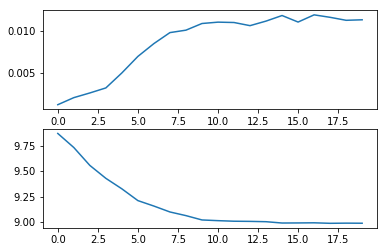

In [133]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

# Визуализируем вектора для разного вида слов до и после тренировки

В случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных) разделяются семантически.

Студенты - в качестве выполненного задания присылайте notebook с диаграммами!

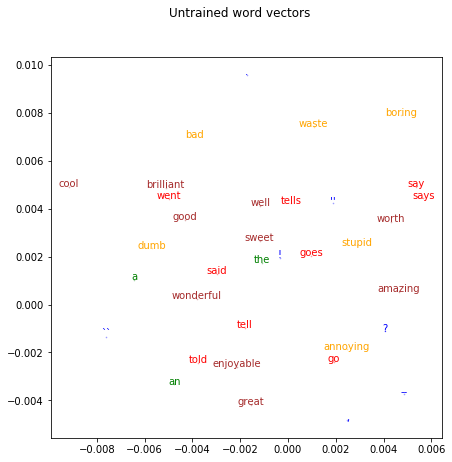

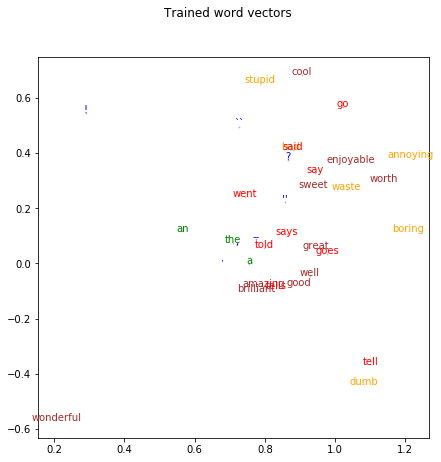

In [134]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors)

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color, horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")

## <center>2 раунд

In [142]:
lrs = np.logspace(-4, -1, num=5)
weight_decays = [0]
step_sizes = [5]
gammas = [0.1]

params_list = [lrs, weight_decays, step_sizes, gammas]

# TODO find the best hyperparameters to train the network

best_loss = np.inf
for params in tqdm_notebook(product(*params_list), total=len(list(product(*params_list)))):
    lr, weight_decay, step_size, gamma = params
    
    nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
    
    optimizer = optim.Adam(nn_model.parameters(), lr=lr, betas=(0.9, 0.999), 
                           eps=1e-08, weight_decay=weight_decay, amsgrad=False)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

    print("\n", "lr, weight_decay, step_size, gamma:", params)
    loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 3)
    loss = loss_history[-1]
    
    if loss <= best_loss:
        best_loss = loss
        best_model = nn_model
        best_history = [loss_history, train_history]
        best_param = params

print('\nbest loss achieved: %f' % best_loss)
print(f"best_param (lr, weight_decay, step_size, gamma): {best_param}")

lr, weight_decay, step_size, gamma: (0.0001, 0, 5, 0.1)


Epoch 0, Average loss: 9.882308, Train accuracy: 0.000085
Epoch 1, Average loss: 9.881731, Train accuracy: 0.000289
Epoch 2, Average loss: 9.881020, Train accuracy: 0.000664
lr, weight_decay, step_size, gamma: (0.0005623413251903491, 0, 5, 0.1)


Epoch 0, Average loss: 9.876781, Train accuracy: 0.000459
Epoch 1, Average loss: 9.806588, Train accuracy: 0.001652
Epoch 2, Average loss: 9.700885, Train accuracy: 0.002724
lr, weight_decay, step_size, gamma: (0.0031622776601683794, 0, 5, 0.1)


Epoch 0, Average loss: 9.799562, Train accuracy: 0.000970
Epoch 1, Average loss: 9.654489, Train accuracy: 0.001998
Epoch 2, Average loss: 9.558326, Train accuracy: 0.002405
lr, weight_decay, step_size, gamma: (0.01778279410038923, 0, 5, 0.1)


Epoch 0, Average loss: 9.883707, Train accuracy: 0.001098
Epoch 1, Average loss: 9.771411, Train accuracy: 0.002522
Epoch 2, Average loss: 9.670215, Train accuracy: 0.003719
lr, weight_decay, step_size, gamma: (0.1, 0, 5, 0.1)


Epoch 0, Average loss: 25.146755, Train accuracy: 0.000170
Epoch 1, Average loss: 34.193651, Train accuracy: 0.000193
Epoch 2, Average loss: 34.624471, Train accuracy: 0.000217

best loss achieved: 9.558326
best_param (lr, weight_decay, step_size, gamma): (0.0031622776601683794, 0, 5, 0.1)


In [144]:
lr, weight_decay, step_size, gamma = (0.003, 0, 5, 0.1)


nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )

optimizer = optim.Adam(nn_model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 20)

Epoch 0, Average loss: 9.800190, Train accuracy: 0.000952
Epoch 1, Average loss: 9.648293, Train accuracy: 0.002461
Epoch 2, Average loss: 9.548189, Train accuracy: 0.002832
Epoch 3, Average loss: 9.491882, Train accuracy: 0.002822
Epoch 4, Average loss: 9.420652, Train accuracy: 0.003507
Epoch 5, Average loss: 9.358252, Train accuracy: 0.005009
Epoch 6, Average loss: 9.324788, Train accuracy: 0.004935
Epoch 7, Average loss: 9.281312, Train accuracy: 0.005435
Epoch 8, Average loss: 9.272539, Train accuracy: 0.005199
Epoch 9, Average loss: 9.245434, Train accuracy: 0.005239
Epoch 10, Average loss: 9.235230, Train accuracy: 0.005771
Epoch 11, Average loss: 9.218877, Train accuracy: 0.005878
Epoch 12, Average loss: 9.220950, Train accuracy: 0.005186
Epoch 13, Average loss: 9.222842, Train accuracy: 0.005486
Epoch 14, Average loss: 9.213858, Train accuracy: 0.005844
Epoch 15, Average loss: 9.216831, Train accuracy: 0.005691
Epoch 16, Average loss: 9.207503, Train accuracy: 0.005800
Epoch 1

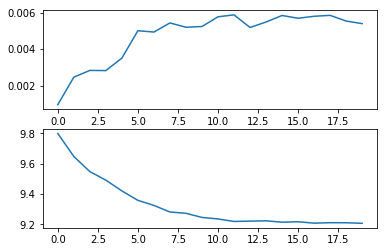

In [145]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)